<a href="https://colab.research.google.com/github/lustraka/Data_Analysis_Workouts/blob/main/Analyse_Twitter_Data/act_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Breeds Popularity

What are the most popular dog breeds? Let's compare the official statistics with data wrangled from social media.

The American Kennel Club (AKC) is the recognized and trusted expert in breed, health and training information for dogs. It publishes the most popular dog breeds based on AKC registration statistics. The following table presents the top 5 most popular dog breeds along with their ranks in previous years.

In [1]:
# Import dependencies
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Store dataframes for further processing
from sqlalchemy import create_engine

# Upload the database from GitHub
url_db = 'https://github.com/lustraka/Data_Analysis_Workouts/blob/main/Analyse_Twitter_Data/weratedogsdata_clean.db?raw=true'
r = requests.get(url_db)
with open('weratedogsdata_clean.db', 'wb') as file:
  file.write(r.content)

# Create SQLAlchemy engine and connect to the database
engine = create_engine('sqlite:///weratedogsdata_clean.db')

# Read dataframes from SQlite database
df_clean = pd.read_sql('SELECT * FROM df_clean', engine)


Breed | 2020 Rank | 2018 Rank |2017 Rank | 2016 Rank | 2015 Rank | 2014 Rank
:---|:---:|:---:|:---:|:---:|:---:|:---:
Labrador Retrievers | 1 | 1 | 1 | 1 | 1 | 1 
French Bulldogs | 2 | 4 | 4 | 6 | 6 | 9   
German Shepherd Dogs | 3 | 2 | 2 | 2 | 2 | 2  
Golden Retrievers |	4 | 3 | 3 | 3 | 3 | 3 
Bulldogs| 5 | 5 | 5 | 4 | 4 | 4 

*Table 1: Top 5 Dog Breeds in 2020. Source:  [AKC](https://www.akc.org/)*

> "America continues its love affair with the Labrador Retriever which tops the list for the 30th year in a row. Just below the Lab, the Frenchie takes the #2 spot, ranking above the German Shepherd Dog and Golden Retriever for the first time." [[Jan Reisen](https://www.akc.org/expert-advice/dog-breeds/the-most-popular-dog-breeds-of-2020/)]

**Can we justify this ranking from an independent source?** We wrangled data from an archive of [WeRateDogs](https://twitter.com/dog_rates) Twitter account as a part of Udacity's [Data Analyst Nanodegree Program](https://www.udacity.com/course/data-analyst-nanodegree--nd002). WeRateDogs Twitter account rates people's dogs with a humorous comment about the dog. It's likely that pop culture plays a large role in dog breeds preferences. For most of the twentieth century, even the breed’s temperament, health, and longevity played less of a role in selecting a dog than did association with a popular film. So, when analyzing the popular Twitter account started in 2015 by college student Matt Nelson, we can expect similar results.

The core WeRateDogs data set contains all tweets from the November 15th, 2015 to the August 17th, 2017. We focus on original ratings (no retweets or replies) that have images. As these tweets don't identify the dog's breed, the tweet images was run through a machine learning algorithm to classify the breed. We used the most confident predictions along with the number of likes to compile this ranking:

In [2]:
# Group a data set by breed and compute sum and mean of favorite count
breed_fav = pd.DataFrame([df_clean.groupby('breed')['favorite_count'].sum(), df_clean.groupby('breed')['favorite_count'].mean()], index=['favorite_sum', 'favorite_mean']).T
# Add ranking
breed_fav['sum_rank'] = breed_fav.favorite_sum.rank(ascending=False)
breed_fav['mean_rank'] = breed_fav.favorite_mean.rank(ascending=False)

# Select top x dog breeds
top = 5
breed_fav_top = breed_fav.query(f'sum_rank <= {top} or mean_rank <= {top}')



In [3]:
# df_clean.timestamp.min(), df_clean.timestamp.max()

In [4]:
def get_count(df, v):
  """Get count of variable v in dataframe df in string format"""

  count = df.query(f'breed == "{v}"')['tweet_id'].count()
  return f' ({count})'

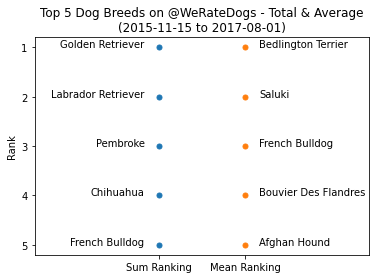

In [5]:
fig, ax = plt.subplots()
rank = breed_fav_top.query(f'sum_rank <= {top}')
for b in rank.index:
  plt.plot(2.3, rank.at[b, 'sum_rank'], marker='o', color='tab:blue', markersize=5)
  plt.text(2.15, rank.at[b, 'sum_rank'], b, ha='right')
rank = breed_fav_top.query(f'mean_rank <= {top}')
for b in rank.index:
  plt.plot(3.2, rank.at[b, 'mean_rank'], marker='o', color='tab:orange', markersize=5)
  plt.text(3.35, rank.at[b, 'mean_rank'], b)

# Rendering
plt.xlim([1, 4.5])
plt.xticks(ticks=[2.3, 3.2], labels=['Sum Ranking', 'Mean Ranking'])
plt.gca().invert_yaxis()
plt.yticks([1, 2, 3, 4, 5])
plt.ylabel('Rank')
plt.title(f'Top {top} Dog Breeds on @WeRateDogs - Total & Average\n(2015-11-15 to 2017-08-01)')

plt.show()

*Figure 1: Top 5 Dog Breeds*

Figure 1 presents two rankings. The Sum Ranking on the left reflects the total number of likes. This is an absolute popularity, which more or less corresponds to the AKC ranking. On the right side, the Mean Ranking reflects the average number of the tweet's likes. Here the ranks are quite different. Only Frenchie justified his popularity. **How is this possible?**

Well, the one reason is statistics. When computing an average we divide the sum of the likes by the number of tweets. Therefore, the fewer tweets with higher favorite count outperform the most frequent tweets. This is illustrated by the sequence of following histograms, which display the frequency of tweets versus the number of likes. The legend in brackets presents also the total number of tweets.

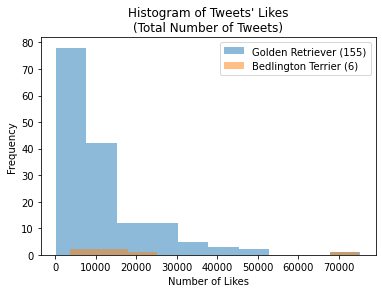

In [6]:
def compare_hist(df, v1, v2):
  """Draw histograms of variabels v1 and v2 from dataframe df."""

  df.query(f'breed == "{v1}"')['favorite_count'].plot(kind='hist', alpha=.5, label=v1+get_count(df,v1))
  df.query(f'breed == "{v2}"')['favorite_count'].plot(kind='hist', alpha=.5, label=v2+get_count(df,v2))
  plt.legend()
  plt.title('Histogram of Tweets\' Likes\n(Total Number of Tweets)')
  plt.xlabel('Number of Likes')
  plt.show()

compare_hist(df_clean, 'Golden Retriever', 'Bedlington Terrier')

*Figure 2a: Histogram for the #1 spot*

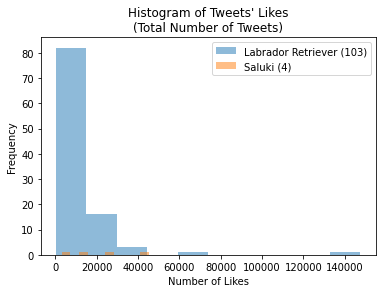

In [7]:
compare_hist(df_clean, 'Labrador Retriever', 'Saluki')

*Figure 2b: Histogram for the #2 spot*

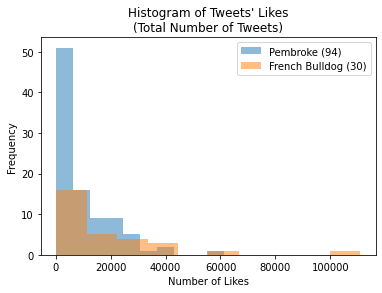

In [8]:
compare_hist(df_clean, 'Pembroke', 'French Bulldog')

*Figure 2c: Histogram for the #3 spot*

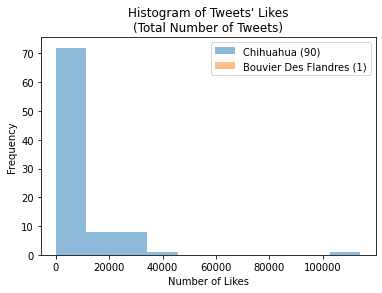

In [9]:
compare_hist(df_clean, 'Chihuahua', 'Bouvier Des Flandres')

*Figure 2d: Histogram for the #4 spot*

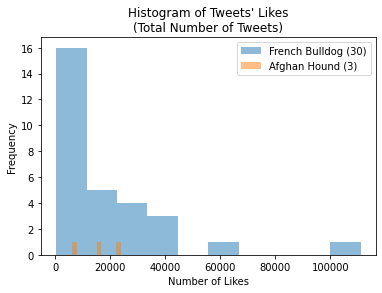

In [10]:
compare_hist(df_clean, 'French Bulldog', 'Afghan Hound')

*Figure 2e: Histogram for the #5 spot*

These histograms are very similar except the histogram 2c which shows more balanced tweet frequency for Pembroke and Frech Bulldog.

Of course, besides the statistics, the Mean Ranking is more then Sum Ranking influenced by the humorous comments accompanying the images. To dig a bit deeper, Figure 3 shows the slope diagram. Here we have complete picture of both total and average rankings.

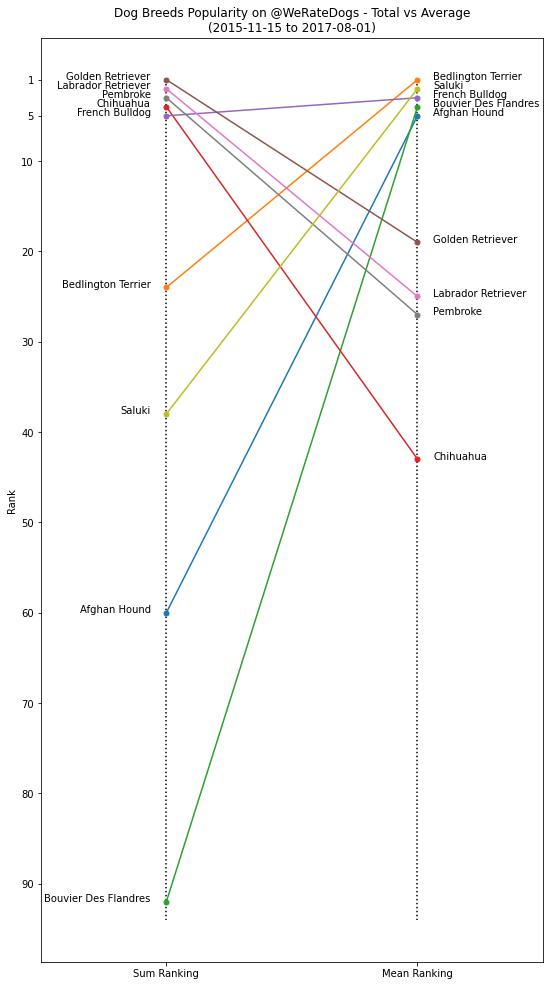

In [11]:
fig, ax = plt.subplots(1, figsize=(9,17))
for b in breed_fav_top.index:
  temp = breed_fav_top[breed_fav_top.index == b]
  plt.plot([2, 6], [temp.sum_rank, temp.mean_rank], marker='o', markersize=5)
  # Sum rank text
  plt.text(1.75, temp.sum_rank, b, ha='right')
  # Mean rank text
  plt.text(6.25, temp.mean_rank, b)
plt.vlines(2, 1, 94, linestyle='dotted')
plt.vlines(6, 1, 94, linestyle='dotted')
# Rendering
plt.xlim([0, 8])
plt.xticks(ticks=[2, 6], labels=['Sum Ranking', 'Mean Ranking'])
plt.gca().invert_yaxis()
plt.yticks([1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90])
plt.ylabel('Rank')
plt.title('Dog Breeds Popularity on @WeRateDogs - Total vs Average\n(2015-11-15 to 2017-08-01)')
plt.show()

*Figure 3: Slope Diagram for the Sum and Mean Rankings*

**In conclusion**:
- An analysis of WeRateDogs data seems to confirm popularity of dog breeds even though the breed of dogs is not the primary concern of this popular Twitter account.
- Rankings based on total number of tweet likes is more appropriate than using the average (mean) values because of different sample sizes of the distinct dog breeds.
- The analysis from years 2015 to 2017 somehow foresees rising popularity of Frenchie 😉.

![Loved Frenchie](https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg)

*Lubomir Straka, 2021-10-14*